# Customer Churn Prediction

**Objective:**
Build a predictive model to identify customers at high risk of churn for a telecom company based
on synthetically generated customer data

# Step 1: Import all Libraries required for the project

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np


In [15]:
# Set random seed for reproducibility in np
np.random.seed(90)

# Task1 : Data Generation
I created a synthetic dataset with 5,000 customer records, including the specified features. Here's how each feature was generated.

**CustomerID**: A unique identifier for each customer, such as "cust1", "cust2",etc

In [4]:
no_records = 5000

customer_ids = [f"Cust{i}" for i in range(1, no_records + 1)]
customer_ids[:5]

['Cust1', 'Cust2', 'Cust3', 'Cust4', 'Cust5']

**Age**: Ages will be normally distributed with an average of 35 and a standard deviation of 9, with values capped between 18 and 80 for realism.

In [8]:
ages = np.clip(np.random.normal(35, 9, no_records), 18, 80).astype(int)
ages[:5]

array([26, 27, 23, 18, 39])

**Gender**: Randomly chosen with an equal 50/50 split between 'Male' and 'Female'.

In [14]:

genders = np.random.choice(['Male', 'Female'], no_records)


print(genders[:15])


['Female' 'Female' 'Female' 'Male' 'Female' 'Male' 'Female' 'Female'
 'Male' 'Female' 'Female' 'Female' 'Female' 'Male' 'Male']


**ContractType**: Categorical distribution with probabilities:

Month-to-month: 60%
One year: 25%
Two years: 15%

In [16]:

contract_options = ['Month-to-month', 'One year', 'Two year']
probabilities = [0.6, 0.25, 0.15]


contract_types = np.array([np.random.choice(contract_options, p=probabilities) for _ in range(no_records)])




In [61]:
contract_types[:15]

array(['One year', 'Month-to-month', 'One year', 'Month-to-month',
       'One year', 'One year', 'Month-to-month', 'Month-to-month',
       'Month-to-month', 'Month-to-month', 'Month-to-month', 'Two year',
       'Month-to-month', 'Two year', 'Month-to-month'], dtype='<U14')

**MonthlyCharges**:Normally distributed charges with a mean of ₹800 and a standard deviation of ₹400. The charges are capped between ₹200 and ₹1500.


In [21]:

mean_charge = 800
std_dev = 400


monthly_charges_raw = np.random.normal(loc=mean_charge, scale=std_dev, size=no_records)

monthly_charges = np.maximum(np.minimum(monthly_charges_raw, 1500), 200)


In [22]:
monthly_charges[:9]

array([1020.0794104 , 1310.89973764,  679.60689755,  200.        ,
        821.85985682,  612.58147911,  862.58878409,  530.79845716,
        266.24569379])

**InternetService**: Categorical distribution:

* DSL: 35%
* Fiber optic: 50%
* No: 15%

In [25]:

service_options = ['DSL', 'Fiber optic', 'None']
probabilities = [0.35, 0.50, 0.15]


internet_services = np.random.choice(service_options, size=no_records, p=probabilities)


In [28]:
internet_services[:4]

array(['Fiber optic', 'Fiber optic', 'None', 'Fiber optic'], dtype='<U11')

**TechSupport**: Randomly chosen with a distribution favoring no tech support:

* Yes: 40%
* No: 60%

In [31]:
tech_support = np.random.choice(['Yes', 'No'], no_records, p=[0.4, 0.6])

In [32]:
tech_support[:5]

array(['No', 'Yes', 'Yes', 'No', 'Yes'], dtype='<U3')

**Tenure**:Uniformly distributed tenures ranging from 1 to 99 months.

In [45]:
tenures = np.random.randint(1, 100, no_records)

In [42]:
tenures[:8]

array([19, 51, 77,  9, 91, 81, 86, 71])

**PaperlessBilling**: 60% of customers use paperless billing.

In [36]:
paperless_billing = np.random.choice(['Yes', 'No'], no_records, p=[0.6, 0.4])

In [37]:
paperless_billing

array(['Yes', 'Yes', 'No', ..., 'Yes', 'Yes', 'No'], dtype='<U3')

**PaymentMethod**: Random selection among:

* Electronic check: 25%
* Mailed check: 15%
* Bank transfer: 30%
* Credit card: 30%

In [38]:
payment_methods = np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], no_records, p=[0.25, 0.15, 0.30, 0.30])

In [39]:
payment_methods

array(['Credit card', 'Credit card', 'Mailed check', ..., 'Mailed check',
       'Mailed check', 'Credit card'], dtype='<U16')

In [47]:

calculated_charges = monthly_charges * tenures


noise = np.random.normal(loc=10, scale=25, size=no_records)
total_charges = calculated_charges + noise


total_charges = np.maximum(total_charges, monthly_charges * 1.1)


In [62]:
print("Total Charges =",total_charges[:10])

Total Charges = [ 7164.59597083  9148.02575347  3387.22325908  6019.01261472
 63330.03006328 52696.08068662 67306.19571854 21235.19092055
 22108.88030258 39370.4363925 ]


**Churn**: The goal is to achieve a 20% churn rate, with churn likelihood influenced by factors such as contract type, tenure, and internet service.



In [54]:

churn_probs = np.where(contract_types == 'Month-to-month', 0.40, 0.10)

# Generate churn labels with adjusted probabilities
churn = np.random.choice(['Yes', 'No'], size=no_records, p=[0.25, 0.75])


In [55]:
print(churn_probs[:5])
print(churn)

[0.1 0.4 0.1 0.4 0.1]
['No' 'No' 'No' ... 'Yes' 'Yes' 'No']


# Creating Derived Features
**average_monthly_charges**: Calculated as `TotalCharges / Tenure`, with proper handling of cases where tenure is zero.

**customer_lifetime_value**: Estimated using `MonthlyCharges × Tenure × RetentionFactor`, where `RetentionFactor` is 1 for non-churned customers and less than 1 for churned customers.

In [59]:

average_monthly_charges = total_charges / tenures

# customer_lifetime_value 
retention_factor = np.where(churn == 'No', 1.0, 0.9)
customer_lifetime_value = monthly_charges * tenures * retention_factor

In [60]:
customer_lifetime_value[:8]

array([ 7140.55587281,  9176.29816347,  3398.03448777,  6000.        ,
       56954.88807774, 47413.80648318, 60553.73264321, 19108.74445759])

# Creating data frame

In [68]:
df = pd.DataFrame({
    'CustomerID': customer_ids,
    'Age': ages,
    'Gender': genders,
    'ContractType': contract_types,
    'MonthlyCharges': monthly_charges,
    'TotalCharges': total_charges,
    'TechSupport': tech_support,
    'InternetService': internet_services,
    'Tenure': tenures,
    'PaperlessBilling': paperless_billing,
    'PaymentMethod': payment_methods,
    'Churn': churn,
    'AverageMonthlyCharges': average_monthly_charges,
    'CustomerLifetimeValue': customer_lifetime_value
})

In [69]:
df.head()

,CustomerID,Age,Gender,ContractType,MonthlyCharges,TotalCharges,TechSupport,InternetService,Tenure,PaperlessBilling,PaymentMethod,Churn,AverageMonthlyCharges,CustomerLifetimeValue
0,Cust1,26,Female,One year,1020.079410,7164.595971,No,Fiber optic,7,Yes,Credit card,No,1023.513710,7140.555873
1,Cust2,27,Female,Month-to-month,1310.899738,9148.025753,Yes,Fiber optic,7,Yes,Credit card,No,1306.860822,9176.298163
2,Cust3,23,Female,One year,679.606898,3387.223259,Yes,None,5,No,Mailed check,No,677.444652,3398.034488
3,Cust4,18,Male,Month-to-month,200.000000,6019.012615,No,Fiber optic,30,Yes,Bank transfer,No,200.633754,6000.000000
4,Cust5,39,Female,One year,821.859857,63330.030063,Yes,Fiber optic,77,No,Electronic check,Yes,822.467923,56954.888078


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             5000 non-null   object 
 1   Age                    5000 non-null   int64  
 2   Gender                 5000 non-null   object 
 3   ContractType           5000 non-null   object 
 4   MonthlyCharges         5000 non-null   float64
 5   TotalCharges           5000 non-null   float64
 6   TechSupport            5000 non-null   object 
 7   InternetService        5000 non-null   object 
 8   Tenure                 5000 non-null   int64  
 9   PaperlessBilling       5000 non-null   object 
 10  PaymentMethod          5000 non-null   object 
 11  Churn                  5000 non-null   object 
 12  AverageMonthlyCharges  5000 non-null   float64
 13  CustomerLifetimeValue  5000 non-null   float64
dtypes: float64(4), int64(2), object(8)
memory usage: 547.0+ 

# Creating  Data Quality Issues

**Missing Values**: 
Introduce missing values in approximately 9% of the MonthlyCharges and Tenure fields.

In [71]:

missing_values = np.random.choice(no_records, size=int(no_records * 0.09), replace=False)


df.loc[missing_values, 'MonthlyCharges'] = np.nan

# Apply missing values to 'Tenure'
df.loc[missing_values, 'Tenure'] = np.nan


In [72]:
df.isna().sum()

CustomerID                 0
Age                        0
Gender                     0
ContractType               0
MonthlyCharges           450
TotalCharges               0
TechSupport                0
InternetService            0
Tenure                   450
PaperlessBilling           0
PaymentMethod              0
Churn                      0
AverageMonthlyCharges      0
CustomerLifetimeValue      0
dtype: int64

**Outliers**: Introduce outliers in TotalCharges by randomly inflating the values for 2% of the data.

In [118]:
outliers = np.random.choice(no_records, size=int(no_records * 0.02), replace=False)
df.loc[outlier_indices, 'TotalCharges'] *= np.random.uniform(1.5, 3.0, size=len(outliers))

**Adding inconsistencies** (TotalCharges lower than MonthlyCharges * Tenure)

In [119]:
inconsistent_indices = np.random.choice(no_records, size=int(no_records * 0.01), replace=False)
df.loc[inconsistent_indices, 'TotalCharges'] = df.loc[inconsistent_indices, 'MonthlyCharges'] * np.random.uniform(0.5, 1.0, size=len(inconsistent_indices))

In [120]:
df.TotalCharges[:5]

0     7164.595971
1     9148.025753
2     3387.223259
3     6019.012615
4    63330.030063
Name: TotalCharges, dtype: float64

In [125]:
expect_total_charges = df['MonthlyCharges'] * df['Tenure']

In [126]:
# Identify inconsistencies
inconsis_rows = df.loc[(df['TotalCharges'] < expect_total_charges ) | 
                             (df['TotalCharges'] > expect_total_charges)]

In [127]:
len(inconsis_rows)

4550

# TASK2 : Exploratory Data Analysis (EDA)

**Summary statistics** for df(sample)


In [91]:
df.describe()

,Age,MonthlyCharges,TotalCharges,Tenure,AverageMonthlyCharges,CustomerLifetimeValue
count,5000.000000,4550.000000,5000.000000,4550.000000,5000.000000,5000.000000
mean,34.291200,807.051782,40251.681617,49.850769,806.995874,39199.267749
std,8.665715,358.791800,31136.648162,28.748413,358.717046,30401.324890
min,18.000000,200.000000,220.000000,1.000000,192.723072,200.000000
25%,28.000000,543.969962,15085.283626,25.000000,545.506772,14720.198462
50%,34.000000,799.440390,33072.923380,49.000000,799.355265,32354.422778
75%,40.000000,1068.925168,60032.494352,75.000000,1067.380365,58430.666521
max,72.000000,1500.000000,148493.731428,99.000000,1650.000000,148500.000000


categorical features

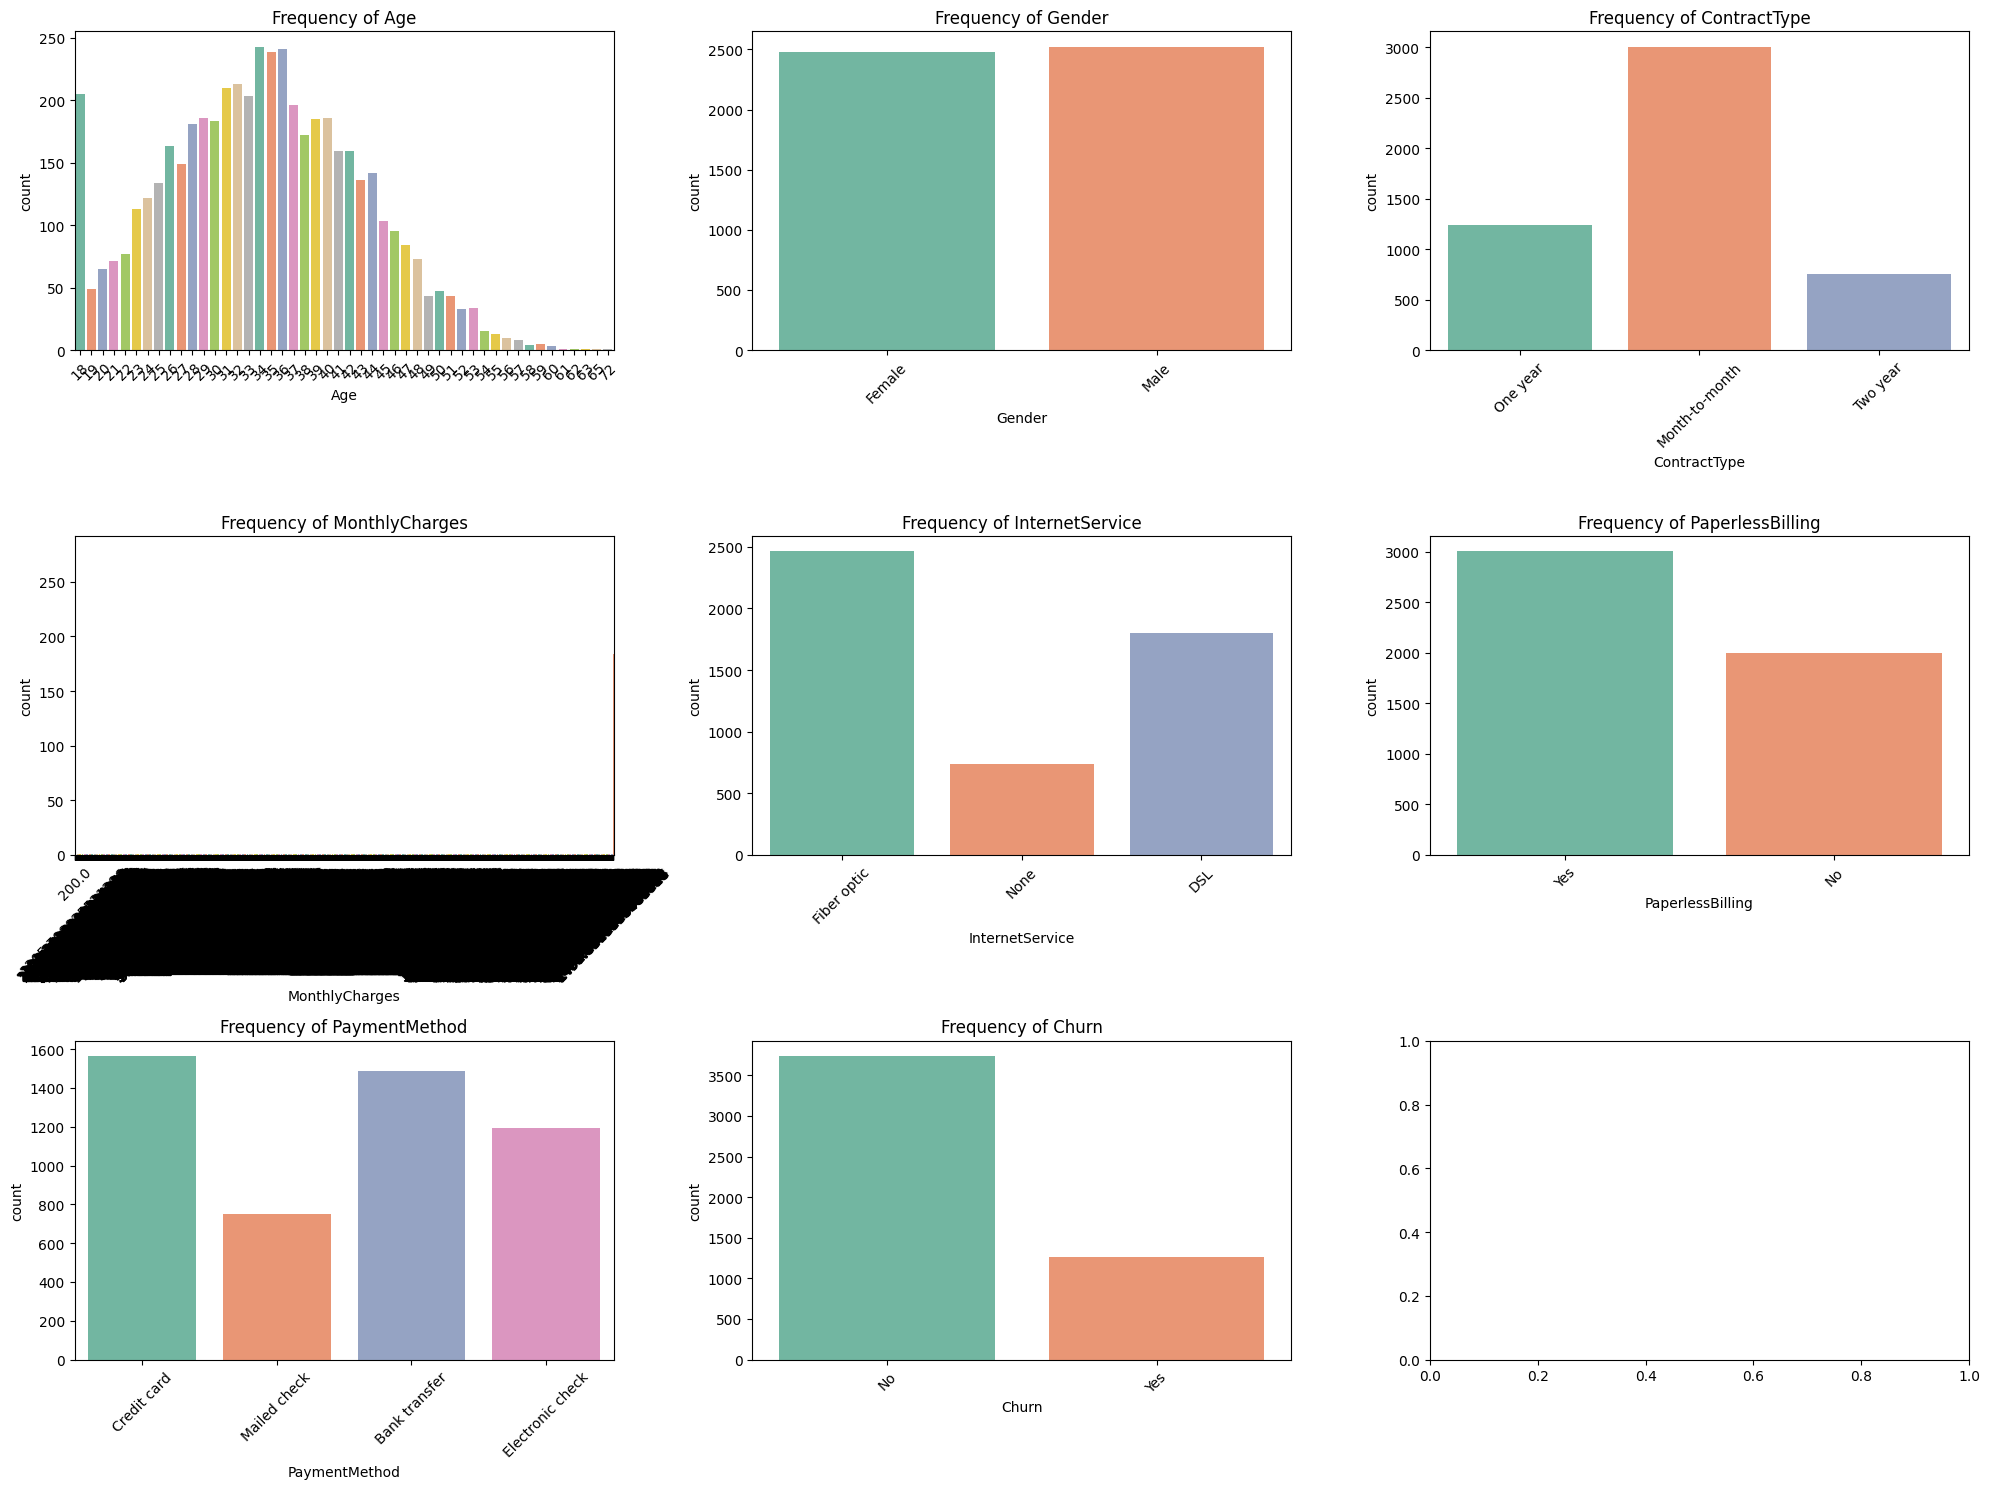

In [96]:
categorical_features = ["Age", 'Gender', 'ContractType', 'MonthlyCharges', 'InternetService', 'PaperlessBilling', 'PaymentMethod', 'Churn']


fig, axes = plt.subplots(3, 3, figsize=(20, 15))


axes = axes.flatten()

# Plot each categorical feature
for idx, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=df, palette='Set2', ax=axes[idx])
    axes[idx].set_title(f'Frequency of {feature}')
    axes[idx].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

# Relationship between numerical features and churn

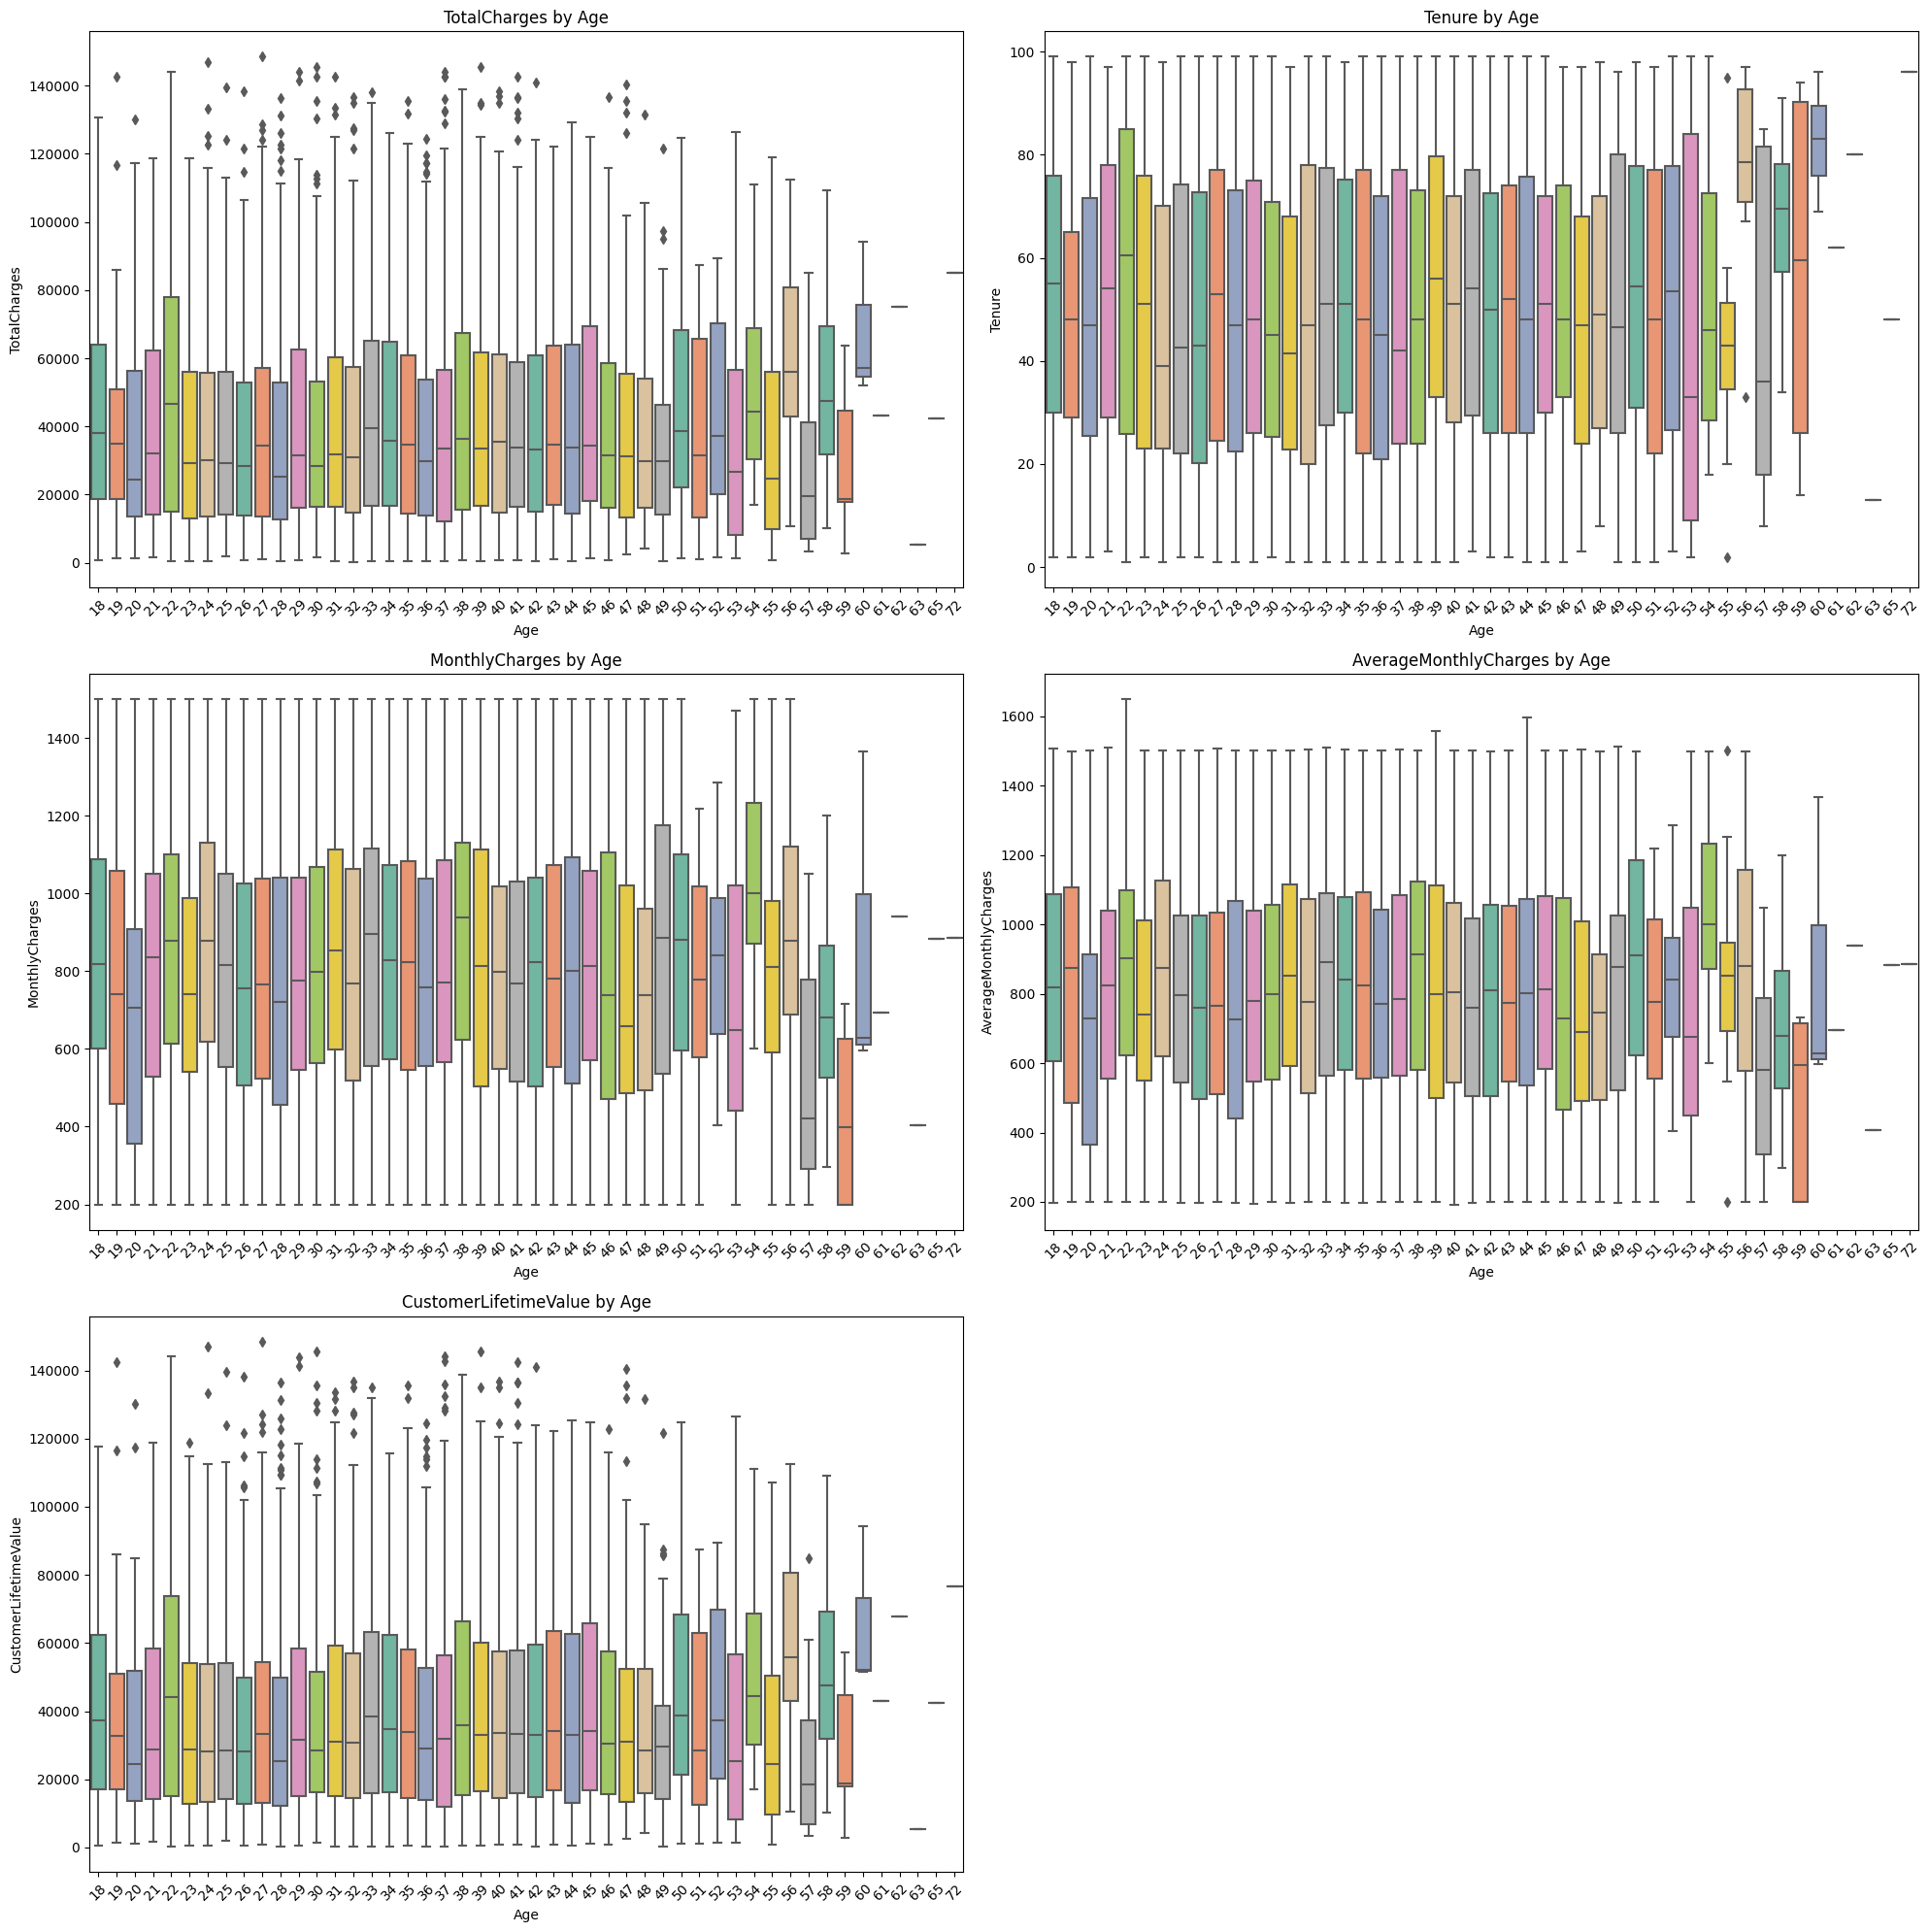

In [104]:

num_features = ['TotalCharges', 'Tenure', 'MonthlyCharges', 'AverageMonthlyCharges', 'CustomerLifetimeValue']


plt.figure(figsize=(20, 20))


for i, feature in enumerate(num_features):
    plt.subplot(3, 2, i + 1)
    
    # Check if feature is numeric, if not, convert it or handle accordingly
    if pd.api.types.is_numeric_dtype(df[feature]):
        sns.boxplot(x='Age', y=feature, data=df, palette='Set2')
    else:
        print(f"Warning: '{feature}' is not numeric and will not be plotted.")
    
    plt.title(f'{feature} by Age')
    plt.xticks(rotation=45)


plt.tight_layout()
plt.show()


# Correlation matrix 

In [105]:
num_features = ['Age', 'MonthlyCharges', 'TotalCharges', 'Tenure', 'AverageMonthlyCharges', 'CustomerLifetimeValue']

# Calculate the correlation matrix
correlation_matrix = data[num_features].corr()


correlation_matrix

,Age,MonthlyCharges,TotalCharges,Tenure,AverageMonthlyCharges,CustomerLifetimeValue
Age,1.000000,-0.005250,0.019996,0.020570,-0.004866,0.014541
MonthlyCharges,-0.005250,1.000000,0.258294,0.008776,0.999692,0.575313
TotalCharges,0.019996,0.258294,1.000000,0.338796,0.256263,0.446093
Tenure,0.020570,0.008776,0.338796,1.000000,0.004059,0.748895
AverageMonthlyCharges,-0.004866,0.999692,0.256263,0.004059,1.000000,0.570976
CustomerLifetimeValue,0.014541,0.575313,0.446093,0.748895,0.570976,1.000000


** Visualize the Correlation Matrix with a Heatmap**

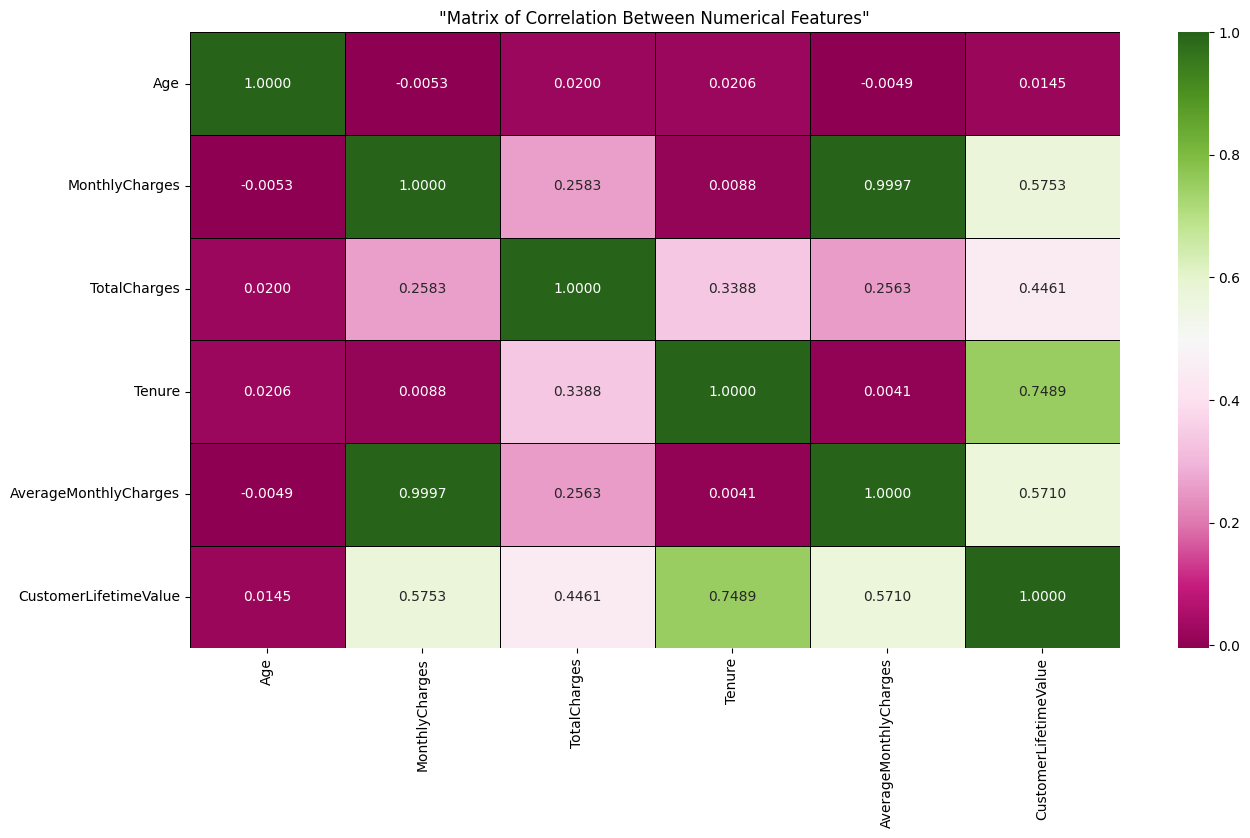

In [112]:
plt.figure(figsize=(15, 8))
#headmap
sns.heatmap(correlation_matrix, annot=True, fmt='.4f', cmap='PiYG', linewidths=0.5, linecolor='black')

plt.title('"Matrix of Correlation Between Numerical Features"')

plt.show()

In [113]:
correlation_matrix[(correlation_matrix > 0.7) & (correlation_matrix != 1.0)].dropna(how='all', axis=0).dropna(how='all', axis=1)


,MonthlyCharges,Tenure,AverageMonthlyCharges,CustomerLifetimeValue
MonthlyCharges,NaN,NaN,0.999692,NaN
Tenure,NaN,NaN,NaN,0.748895
AverageMonthlyCharges,0.999692,NaN,NaN,NaN
CustomerLifetimeValue,NaN,0.748895,NaN,NaN


**Visualize Categorical Features vs. Churn**

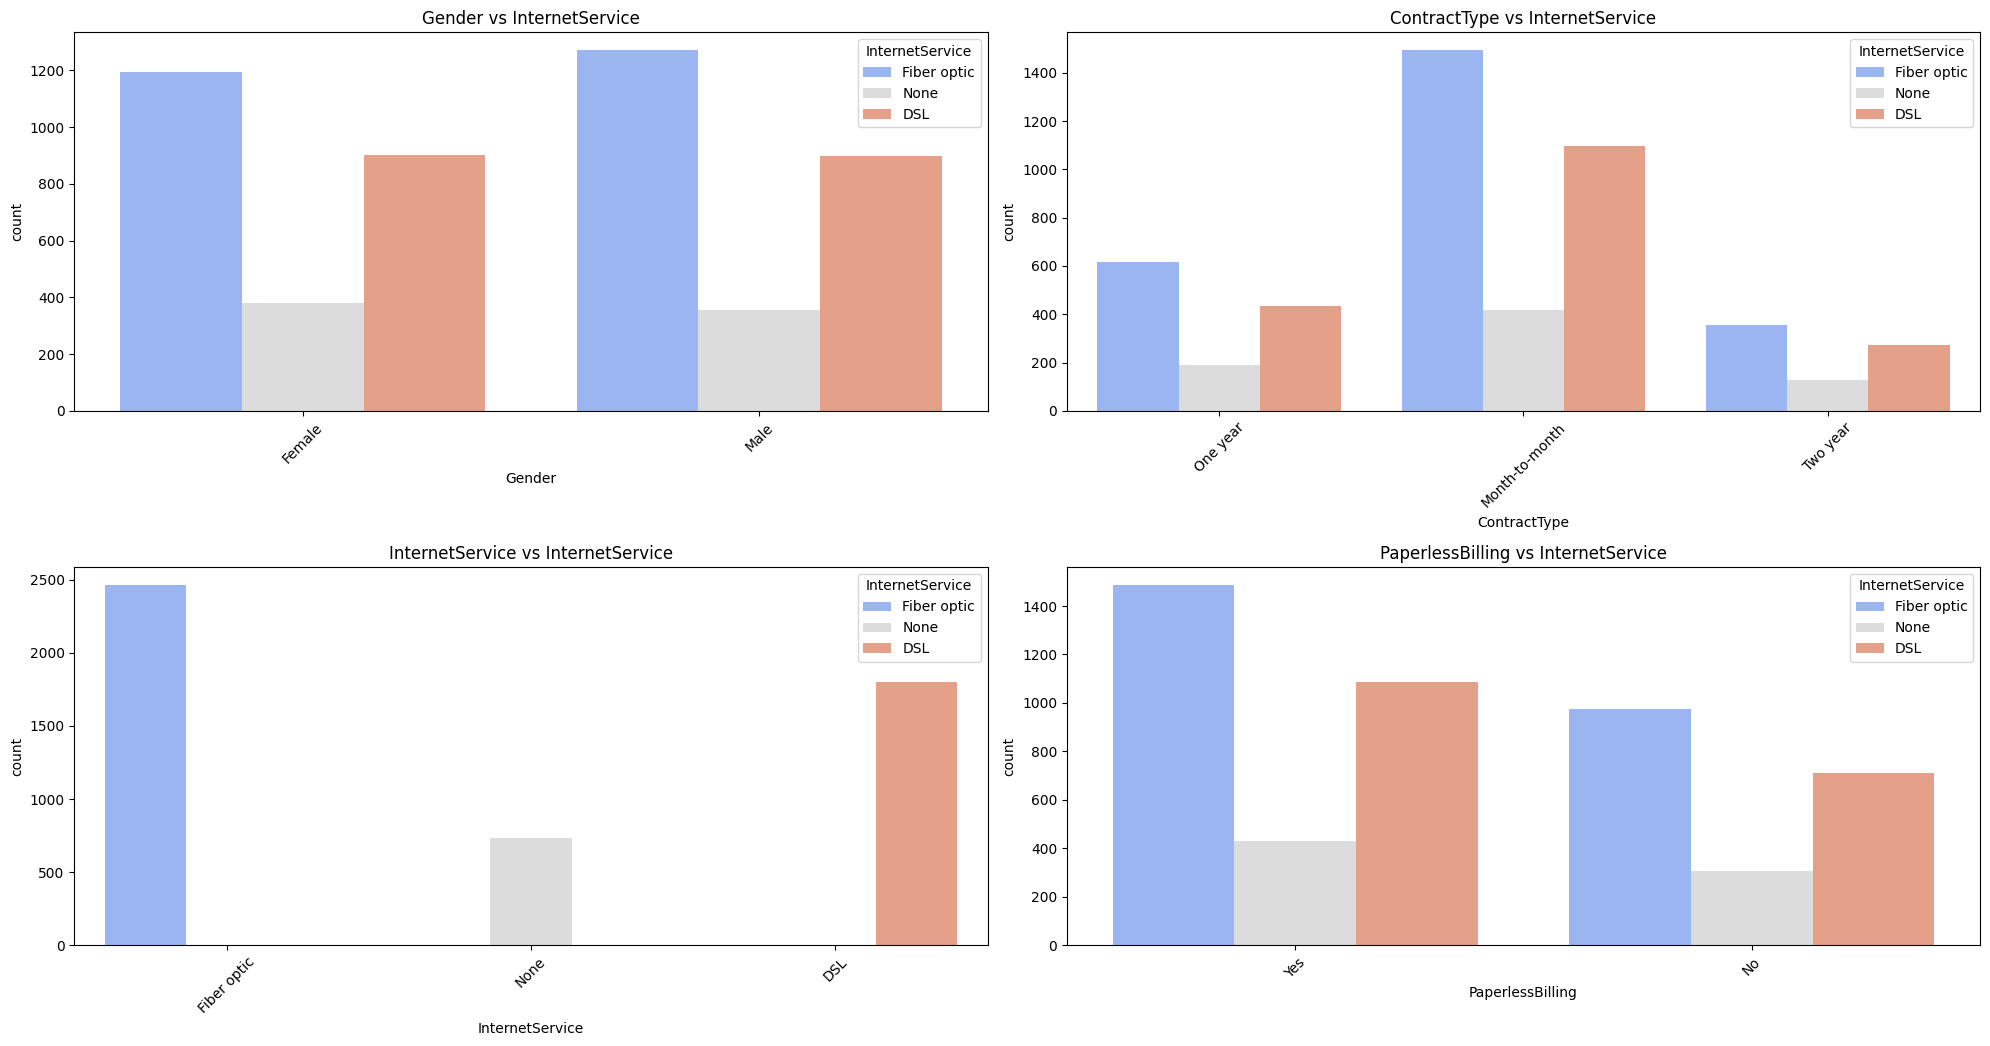

In [114]:
categorical_features = ['Gender', 'ContractType', 'InternetService', 'PaperlessBilling', 'PaymentMethod']


plt.figure(figsize=(20, 15))

# Subplots for feature comparisons
for i, feature in enumerate(categorical_features[:-1]):  # Exclude the last feature if needed
    plt.subplot(3, 2, i + 1)
    sns.countplot(x=feature, hue='InternetService', data=df, palette='coolwarm')
    plt.title(f'{feature} vs InternetService')
    plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

# TASK3 : Data Preprocessing

**Handle Missing Values**

In [117]:

missing_values = df.isnull().sum()
print("Missing values before handling:")
print(missing_values[missing_values > 0])

Missing values before handling:
MonthlyCharges    450
Tenure            450
dtype: int64


In [128]:
# Fill missing values in 'MonthlyCharges' with mean
df['MonthlyCharges'].fillna(df['MonthlyCharges'].mean(), inplace=True)

/tmp/ipykernel_36/1085292209.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyCharges'].fillna(df['MonthlyCharges'].mean(), inplace=True)


In [129]:
df.MonthlyCharges.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5000 entries, 0 to 4999
Series name: MonthlyCharges
Non-Null Count  Dtype  
--------------  -----  
5000 non-null   float64
dtypes: float64(1)
memory usage: 39.2 KB


In [130]:
# Fill missing values in 'Tenure' with median
df['Tenure'].fillna(df['Tenure'].median(), inplace=True)

/tmp/ipykernel_36/3563801387.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tenure'].fillna(df['Tenure'].median(), inplace=True)


In [131]:
df.Tenure.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5000 entries, 0 to 4999
Series name: Tenure
Non-Null Count  Dtype  
--------------  -----  
5000 non-null   float64
dtypes: float64(1)
memory usage: 39.2 KB


# Encode Categorical Features

In [132]:
encoder = LabelEncoder()


cat_features = ['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod', 'Churn']

# Apply label encoding to each categorical feature
for feature in cat_features:
    df[feature] = encoder.fit_transform(df[feature])

# Display the first few rows of the DataFrame after encoding
df.head()

,CustomerID,Age,Gender,ContractType,MonthlyCharges,TotalCharges,TechSupport,InternetService,Tenure,PaperlessBilling,PaymentMethod,Churn,AverageMonthlyCharges,CustomerLifetimeValue
0,Cust1,26,0,1,1020.079410,7164.595971,0,1,7.0,1,1,0,1023.513710,7140.555873
1,Cust2,27,0,0,1310.899738,9148.025753,1,1,7.0,1,1,0,1306.860822,9176.298163
2,Cust3,23,0,1,679.606898,3387.223259,1,2,5.0,0,3,0,677.444652,3398.034488
3,Cust4,18,1,0,807.051782,6019.012615,0,1,49.0,1,0,0,200.633754,6000.000000
4,Cust5,39,0,1,821.859857,63330.030063,1,1,77.0,0,2,1,822.467923,56954.888078


# TASK4 : Feature Engineering:

In [133]:

df['AvgMonthlyCharges'] = df['TotalCharges'] / (df['Tenure'] + 1)  # Adding 1 to avoid division by zero

df['CustLifetimeValue'] = df['MonthlyCharges'] * df['Tenure']


df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, np.inf], labels=['<30', '30-40', '40-50', '50-60', '60+'])


df['LogTotalCharges'] = np.log1p(df['TotalCharges'])

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CustomerID             5000 non-null   object  
 1   Age                    5000 non-null   int64   
 2   Gender                 5000 non-null   int64   
 3   ContractType           5000 non-null   int64   
 4   MonthlyCharges         5000 non-null   float64 
 5   TotalCharges           4996 non-null   float64 
 6   TechSupport            5000 non-null   int64   
 7   InternetService        5000 non-null   int64   
 8   Tenure                 5000 non-null   float64 
 9   PaperlessBilling       5000 non-null   int64   
 10  PaymentMethod          5000 non-null   int64   
 11  Churn                  5000 non-null   int64   
 12  AverageMonthlyCharges  5000 non-null   float64 
 13  CustomerLifetimeValue  5000 non-null   float64 
 14  AvgMonthlyCharges      4996 non-null   f

**Data Volume**: Reduce the dataset size to simulate real-world constraints.

In [137]:
features = [
    'Age', 'MonthlyCharges', 'TotalCharges', 'Tenure', 'AverageMonthlyCharges', 
    'CustomerLifetimeValue', 'LogTotalCharges', 'AgeGroup'
]

In [138]:
df.head()

,CustomerID,Age,Gender,ContractType,MonthlyCharges,TotalCharges,TechSupport,InternetService,Tenure,PaperlessBilling,PaymentMethod,Churn,AverageMonthlyCharges,CustomerLifetimeValue,AvgMonthlyCharges,CustLifetimeValue,AgeGroup,LogTotalCharges
0,Cust1,26,0,1,1020.079410,7164.595971,0,1,7.0,1,1,0,1023.513710,7140.555873,895.574496,7140.555873,<30,8.877047
1,Cust2,27,0,0,1310.899738,9148.025753,1,1,7.0,1,1,0,1306.860822,9176.298163,1143.503219,9176.298163,<30,9.121403
2,Cust3,23,0,1,679.606898,3387.223259,1,2,5.0,0,3,0,677.444652,3398.034488,564.537210,3398.034488,<30,8.128061
3,Cust4,18,1,0,807.051782,6019.012615,0,1,49.0,1,0,0,200.633754,6000.000000,120.380252,39545.537304,<30,8.702845
4,Cust5,39,0,1,821.859857,63330.030063,1,1,77.0,0,2,1,822.467923,56954.888078,811.923462,63283.208975,30-40,11.056131


In [139]:
data = df[features]

In [141]:

data['AgeGroup'] = encoder.fit_transform(data['AgeGroup'])

/tmp/ipykernel_36/177443646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AgeGroup'] = encoder.fit_transform(data['AgeGroup'])


In [142]:
X = data.drop('Churn', axis=1, errors='ignore')
y = df['Churn']

In [143]:
X.head()

,Age,MonthlyCharges,TotalCharges,Tenure,AverageMonthlyCharges,CustomerLifetimeValue,LogTotalCharges,AgeGroup
0,26,1020.079410,7164.595971,7.0,1023.513710,7140.555873,8.877047,4
1,27,1310.899738,9148.025753,7.0,1306.860822,9176.298163,9.121403,4
2,23,679.606898,3387.223259,5.0,677.444652,3398.034488,8.128061,4
3,18,807.051782,6019.012615,49.0,200.633754,6000.000000,8.702845,4
4,39,821.859857,63330.030063,77.0,822.467923,56954.888078,11.056131,0


In [144]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: Churn, dtype: int64

In [146]:
X_all, X_test, y_all, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.33, random_state=42, stratify=y_all)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (2512, 8)
Validation shape: (1238, 8)
Test shape: (1250, 8)


# Task5: Model Building

**Experiment with various classification algorithms (Logistic Regression, Random Forest,
Gradient Boosting, XGBoost, etc.)**

In [155]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [156]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)


results = {}
for name, model in models.items():
    model.fit(X_train_imputed, y_train)  # Fit model
    y_pred = model.predict(X_val_imputed)  # Predict
    
    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred, zero_division=0),
        'Recall': recall_score(y_val, y_pred, zero_division=0),
        'F1 Score': f1_score(y_val, y_pred, zero_division=0)
    }

In [157]:

for i in results:
    print(i)
    print(results[i])

Logistic Regression
{'Accuracy': 0.7366720516962844, 'Precision': 0.18181818181818182, 'Recall': 0.01282051282051282, 'F1 Score': 0.02395209580838323}
Random Forest
{'Accuracy': 0.8012924071082391, 'Precision': 0.7946428571428571, 'Recall': 0.28525641025641024, 'F1 Score': 0.41981132075471694}
Gradient Boosting
{'Accuracy': 0.8053311793214862, 'Precision': 0.8585858585858586, 'Recall': 0.2724358974358974, 'F1 Score': 0.41362530413625304}
XGBoost
{'Accuracy': 0.9369951534733441, 'Precision': 0.8979591836734694, 'Recall': 0.8461538461538461, 'F1 Score': 0.8712871287128713}


**Optimize model hyperparameters using techniques like Grid Search or Randomized Search.**

In [158]:
param_grids = {
    'Logistic Regression': {
        'C': [0.05, 0.5, 5, 50]
    },
    'Random Forest': {
        'n_estimators': [150, 250],
        'max_depth': [10, 25, 40]
    },
    'Gradient Boosting': {
        'n_estimators': [150],
        'learning_rate': [0.05, 0.2],
        'max_depth': [3, 6]
    },
    'XGBoost': {
        'n_estimators': [150],
        'learning_rate': [0.05, 0.15],
        'max_depth': [4, 6]
    }
}


best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_imputed, y_train)
    best_models[name] = grid_search.best_estimator_

# Show best hyperparameters
for name, model in best_models.items():
    print(f"Best parameters for {name}: {model.get_params()}\n")

Best parameters for Logistic Regression: {'C': 5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Best parameters for Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 25, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Best parameters for Gradient Boosting: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 

**Evaluate model performance using metrics like accuracy, precision, recall, F1-score, ROC curve, AUC.**

In [160]:
imputer = SimpleImputer(strategy='median')


X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

model_results = {}

# Evaluate each best model
for name, model in best_models.items():
    y_pred = model.predict(X_val_imputed)
    
    # Compute metrics
    metrics = {
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1 Score': f1_score(y_val, y_pred)
    }
    
 
    model_results[name] = metrics


results_df = pd.DataFrame(model_results).T


print(results_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.736672   0.181818  0.012821  0.023952
Random Forest        0.805331   0.819820  0.291667  0.430260
Gradient Boosting    0.953958   0.938144  0.875000  0.905473
XGBoost              0.930533   0.909420  0.804487  0.853741


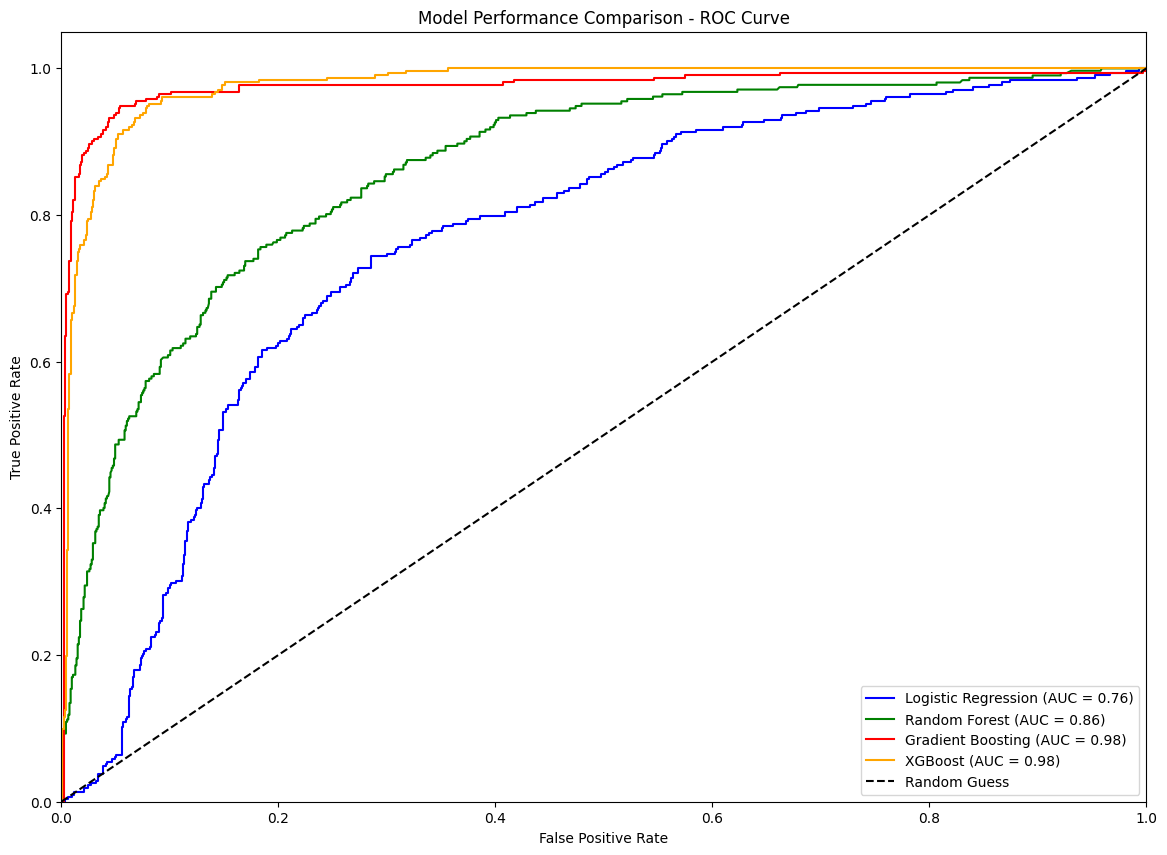

In [161]:
colors = ['blue', 'green', 'red', 'orange']
fig_size = (14, 10)
title_name = 'Model Performance Comparison - ROC Curve'

# Plot ROC Curve
plt.figure(figsize=fig_size)

for (name, model), color in zip(best_models.items(), colors):
    y_pred_proba = model.predict_proba(X_val_imputed)[:, 1]  # Use imputed data
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(title_name)
plt.legend(loc='lower right')
plt.show()

**Ensemble methods for improved performance**

In [162]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [163]:
voting_model = VotingClassifier(
    estimators=[
        ('LR', best_models['Logistic Regression']),
        ('RF', best_models['Random Forest']),
        ('GB', best_models['Gradient Boosting']),
        ('XGB', best_models['XGBoost'])
    ],
    voting='soft'
)

voting_model.fit(X_train_imputed, y_train)  # Ensure X_train_imputed is used if missing values were handled


y_pred = voting_model.predict(X_val_imputed)  # Ensure X_val_imputed is used if missing values were handled

# Compute metrics
ensemble_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred),
    'Precision': precision_score(y_val, y_pred),
    'Recall': recall_score(y_val, y_pred),
    'F1 Score': f1_score(y_val, y_pred)
}


print("Ensemble Model Performance:")
for metric, score in ensemble_metrics.items():
    print(f"{metric}: {score:.2f}")

Ensemble Model Performance:
Accuracy: 0.93
Precision: 0.94
Recall: 0.76
F1 Score: 0.84


# Task6 :Model Selection and Evaluation

**best-performing model based on evaluation metrics**


<Figure size 1000x700 with 0 Axes>

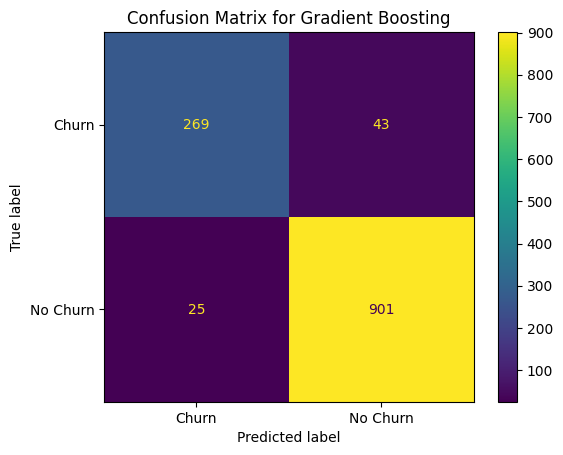

In [169]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


model_name = 'Gradient Boosting'  
selected_model = best_models[model_name]


imputer = SimpleImputer(strategy='mean')  
X_val_imputed = imputer.fit_transform(X_val)


predictions = selected_model.predict(X_val_imputed)

# Create confusion matrix
cm = confusion_matrix(y_val, predictions, labels=[1, 0])  # Assuming '1' for churn and '0' for no churn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn', 'No Churn'])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap='viridis', values_format='d')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


**Calculate Feature Importance**


Feature Importance to Understand Key Drivers of Churn:
CustomerLifetimeValue: 0.384
TotalCharges: 0.273
LogTotalCharges: 0.269
Age: 0.026
Tenure: 0.016
AverageMonthlyCharges: 0.015
MonthlyCharges: 0.014
AgeGroup: 0.003


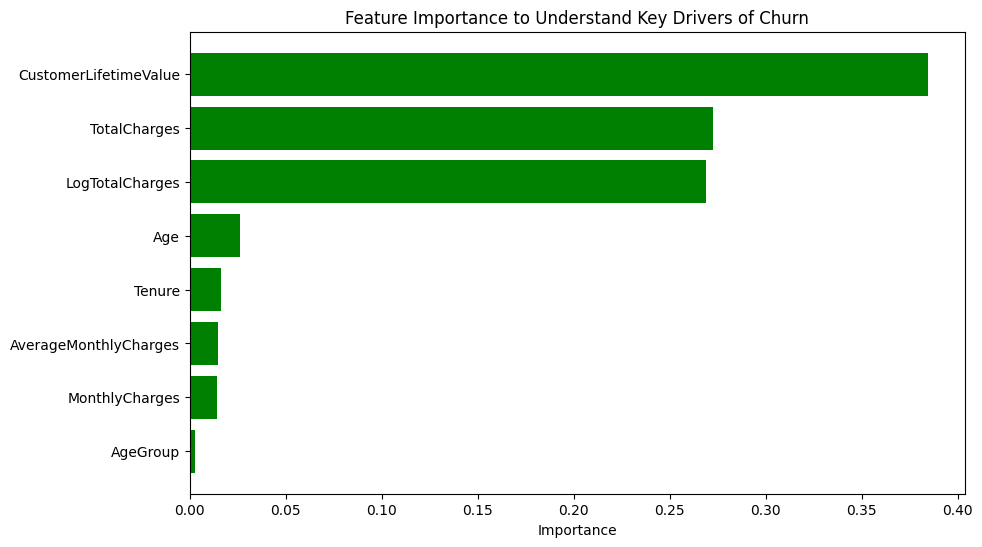

In [176]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt


best_model_name = 'Gradient Boosting'  # Change this to your selected model name
best_model = best_models.get(best_model_name)  # Retrieve the model from best_models

if best_model and hasattr(best_model, 'feature_importances_'):
   
    importances = best_model.feature_importances_
    features = X_train.columns
    sorted_importances = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)

    
    print("Feature Importance to Understand Key Drivers of Churn:")
    for feature, importance in sorted_importances:
        print(f"{feature}: {importance:.3f}")

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh([f[0] for f in sorted_importances], [f[1] for f in sorted_importances], color='green')
    plt.xlabel('Importance')
    plt.title('Feature Importance to Understand Key Drivers of Churn')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Selected model does not support feature importances. Use a tree-based model for this analysis.")
